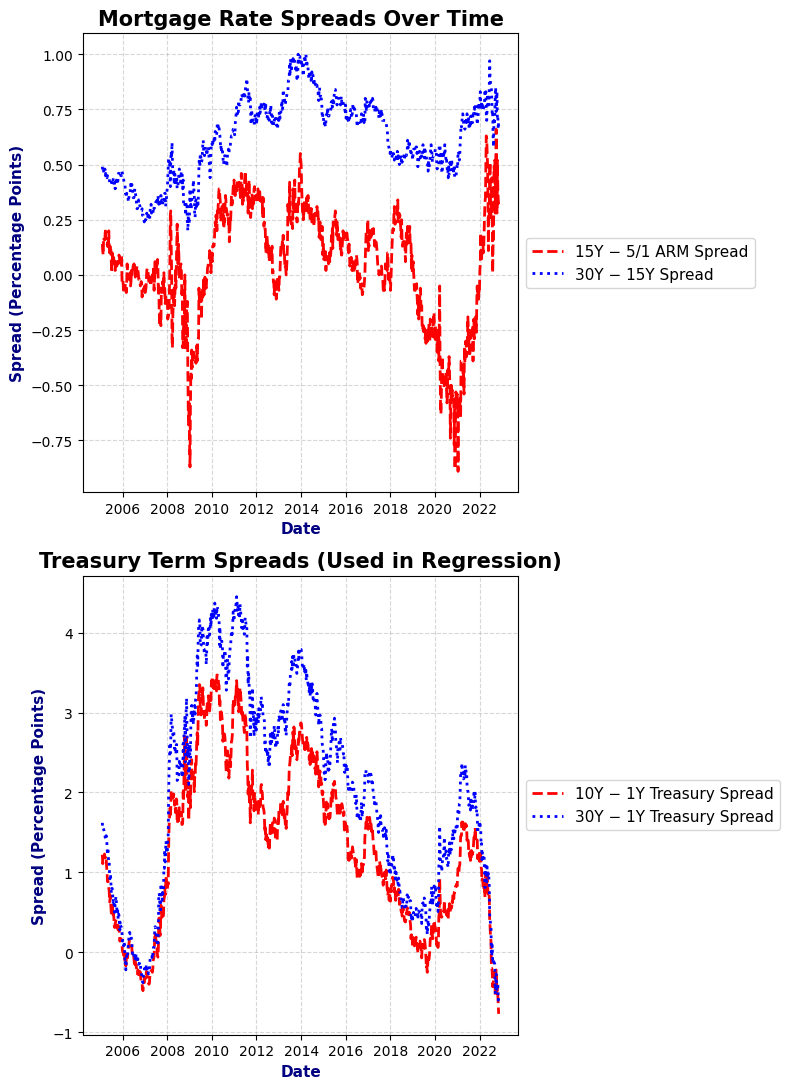

 
 
 
Regression: (15Y − 5/1 ARM) on Treasury spreads
 
                            OLS Regression Results                            
Dep. Variable:            spread_15_5   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     62.92
Date:                Wed, 19 Nov 2025   Prob (F-statistic):           2.40e-26
Time:                        01:23:36   Log-Likelihood:                 4.6537
No. Observations:                 927   AIC:                            -3.307
Df Residuals:                     924   BIC:                             11.19
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

def load_fred(file_name, value_name):
    """
    Loads a FRED CSV file, converts the first column to DATE,
    the second column to a numeric series, and renames them.
    """
    df = pd.read_csv(file_name, na_values=".")
    date_col = df.columns[0]
    val_col = df.columns[1]

    df[date_col] = pd.to_datetime(df[date_col])
    df[val_col] = pd.to_numeric(df[val_col], errors="coerce")

    df = df.rename(columns={date_col: "DATE", val_col: value_name})
    return df[["DATE", value_name]]

# ---------------------------
# 1. Load all series from CSV
# ---------------------------
mort_5_1 = load_fred("MORTGAGE5US.csv", "mort_5_1")  # 5/1 ARM
mort_15  = load_fred("MORTGAGE15US.csv", "mort_15")  # 15-year FRM
mort_30  = load_fred("MORTGAGE30US.csv", "mort_30")  # 30-year FRM

gs1  = load_fred("DGS1.csv",  "gs1")   # 1-year Treasury
gs10 = load_fred("DGS10.csv", "gs10")  # 10-year Treasury
gs30 = load_fred("DGS30.csv", "gs30")  # 30-year Treasury

# ------------------------------------
# 2. Merge everything into one DataFrame
# ------------------------------------
df = mort_5_1.merge(mort_15, on="DATE") \
             .merge(mort_30, on="DATE") \
             .merge(gs1, on="DATE") \
             .merge(gs10, on="DATE") \
             .merge(gs30, on="DATE")

# ------------------------------------
# 3. Filter sample: Jan 2005 – Jun 2025
# ------------------------------------
start_date = "2005-02-01"
end_date   = "2025-06-30"

df = df[(df["DATE"] >= start_date) & (df["DATE"] <= end_date)]

# Drop missing values
df = df.dropna()

# ------------------------------------
# 4. Construct mortgage spreads & Treasury spreads
# ------------------------------------
# Mortgage spreads
df["spread_15_5"]  = df["mort_15"] - df["mort_5_1"]   # 15Y − 5/1 ARM
df["spread_30_15"] = df["mort_30"] - df["mort_15"]    # 30Y − 15Y

# Treasury spreads from Question 5
df["ts_10_1"] = df["gs10"] - df["gs1"]                # 10Y − 1Y
df["ts_30_1"] = df["gs30"] - df["gs1"]                # 30Y − 1Y

# -------------------------------------------------
# 5. Plotting Mortgage & Treasury Spreads (DNN style)
# -------------------------------------------------

plt.figure(figsize=(8, 11))

# Top subplot: mortgage spreads
plt.subplot(2, 1, 1)
plt.plot(df["DATE"], df["spread_15_5"],
         color="red", linestyle="--", linewidth=2,
         label="15Y − 5/1 ARM Spread")

plt.plot(df["DATE"], df["spread_30_15"],
         color="blue", linestyle=":", linewidth=2,
         label="30Y − 15Y Spread")

plt.xlabel("Date", fontsize=11, color="navy", fontweight="bold")
plt.ylabel("Spread (Percentage Points)", fontsize=11, color="navy", fontweight="bold")
plt.title("Mortgage Rate Spreads Over Time", fontsize=15, color="black", fontweight="bold")

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=11)
plt.grid(True, linestyle="--", alpha=0.5)
plt.gca()

# Bottom subplot: Treasury term spreads (from Q5)
plt.subplot(2, 1, 2)
plt.plot(df["DATE"], df["ts_10_1"],
         color="red", linestyle="--", linewidth=2,
         label="10Y − 1Y Treasury Spread")

plt.plot(df["DATE"], df["ts_30_1"],
         color="blue", linestyle=":", linewidth=2,
         label="30Y − 1Y Treasury Spread")

plt.xlabel("Date", fontsize=11, color="navy", fontweight="bold")
plt.ylabel("Spread (Percentage Points)", fontsize=11, color="navy", fontweight="bold")
plt.title("Treasury Term Spreads (Used in Regression)", fontsize=15, color="black", fontweight="bold")

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=11)
plt.grid(True, linestyle="--", alpha=0.5)
plt.gca()

plt.subplots_adjust(hspace=0.5)
plt.tight_layout()
plt.show()

print(f" ")

# ------------------------------------
# 6. Regress mortgage spreads on Treasury spreads
# ------------------------------------
X = df[["ts_10_1", "ts_30_1"]]
X = sm.add_constant(X)   # adds intercept

# Regression 1: (15Y − 5/1 ARM) on Treasury spreads
y1 = df["spread_15_5"]
model1 = sm.OLS(y1, X).fit()
print(f" ")
print(f" ")
print("Regression: (15Y − 5/1 ARM) on Treasury spreads")
print(f" ")
print(model1.summary())

# Regression 2: (30Y − 15Y) on Treasury spreads
y2 = df["spread_30_15"]
model2 = sm.OLS(y2, X).fit()
print(f" ")
print(f" ")
print("\nRegression: (30Y − 15Y) on Treasury spreads")
print(f" ")
print(model2.summary())